<a href="https://colab.research.google.com/github/ducodbs0516/pdm18/blob/main/py-tensorflow/DL2-CNN/dl2_02_mnist_CNN_best_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN model of mnist dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    - > 2차원 필터로 영상을 대표하는 특징을 추출
    * FCN : 1차원 완전연결신경망
    - > Conv2D에서 추출된 대표 특징들을 이용하여 FCN으로 최종 학습 완료

***
- ## Traget: **Find the best model**
***

![mnist_NN_2_layers](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

(source: https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

print(tf.__version__)

tf.random.set_seed(0)

2.7.0


In [2]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [3]:
from keras.datasets import mnist

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

11501568/11490434 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [4]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [5]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((60000,), (60000, 10))

### Display numbers
- one random number
- 10 representative numbers

14909


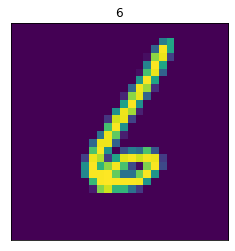

In [6]:
# Code here!
# display one random image from the training set:
class_names = ["0","1","2","3","4","5","6","7","8","9"]

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

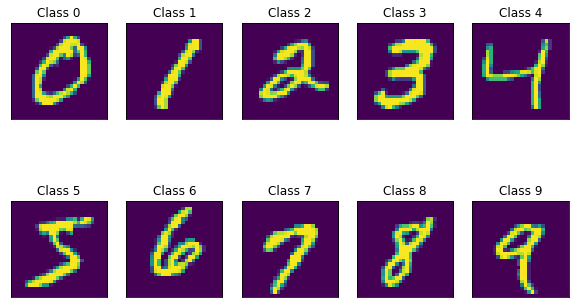

In [7]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

## **CNN2 + FCN2**

In [9]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [10]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [11]:
c2f2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [12]:
mc_callback = callbacks.ModelCheckpoint(filepath="./mnist_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10)    # patience=10, 20, 50
                            # patience=10: 정확도 최대 값이 나온 뒤 10번의 값이 최대 정확도를 넘지 못하면 중단

In [13]:
# Train CNN model
# Find and save the best model.
hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 15s 10ms/step - loss: 0.2204 - accuracy: 0.9330 - val_loss: 0.0513 - val_accuracy: 0.9844
Epoch 2/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0658 - accuracy: 0.9799 - val_loss: 0.0339 - val_accuracy: 0.9885
Epoch 3/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0463 - accuracy: 0.9858 - val_loss: 0.0314 - val_accuracy: 0.9898
Epoch 4/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0303 - val_accuracy: 0.9895
Epoch 5/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0300 - accuracy: 0.9903 - val_loss: 0.0274 - val_accuracy: 0.9910
Epoch 6/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0250 - val_accuracy: 0.9912
Epoch 7/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0222 - accuracy: 0.9927 - val_loss: 0.0248 - val_accuracy: 0

In [14]:
c2f2.evaluate(X_test, y_test, batch_size =100)

100/100 [==============================] - 1s 6ms/step - loss: 0.0301 - accuracy: 0.9931


[0.03009936213493347, 0.9930999875068665]

## Graph of loss and accuracy
- model: C2F2

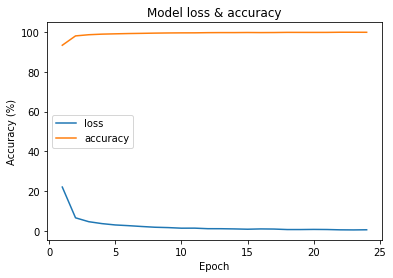

In [15]:
# Plot loass and accuracy
# Plot training & validation accuracy values
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]

epochs = range(1, len(loss_list) + 1)

plt.plot(epochs,loss_list) 
plt.plot(epochs,acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')
plt.show()

In [16]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

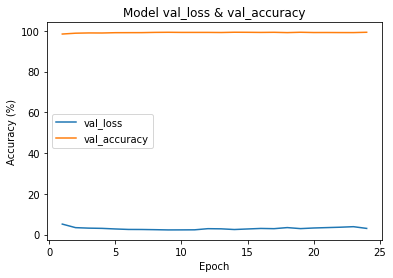

In [17]:
plt.plot(epochs,vloss_list)  
plt.plot(epochs,vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')
plt.show()

In [ ]:
np.argmax(np.array(vacc_list))

In [ ]:
vacc_list[np.argmax(np.array(vacc_list))]

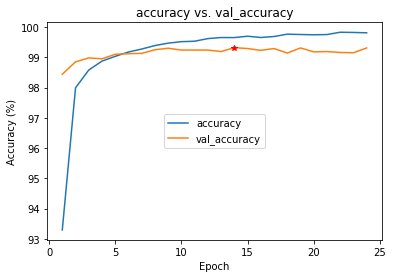

In [20]:
plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 
plt.show()

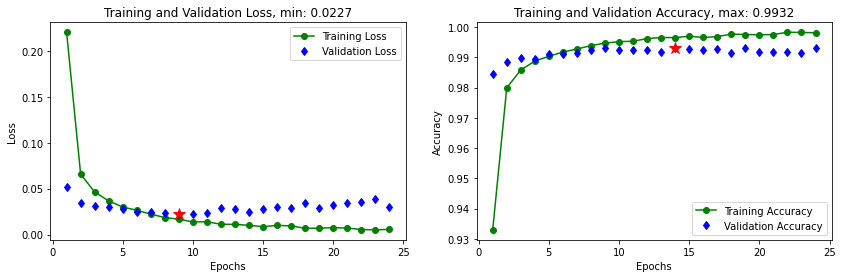

In [21]:
# 중요
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 최적화된 모형 불러와서 이용

- callbacks.ModelCheckpoint를 이용해서 트레이닝 중 val_accuacy가 가장 높은 모형을 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

### Best model
- mnist_c2f2_best_weights.014-0.9932.hdf5

In [22]:
from keras.models import load_model

model = load_model('mnist_c2f2_best_weights.014-0.9932.hdf5')
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 1s 6ms/step - loss: 0.0247 - accuracy: 0.9932


[0.024655485525727272, 0.9932000041007996]

## [DIY] C2F3의 best model을 구하시오.

## **CNN2 + FCN3**

In [23]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [24]:
c2f3 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),filters= 32, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(filters= 64, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [25]:
c2f3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [26]:
mc_callback = callbacks.ModelCheckpoint(filepath="./mnist_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10) 

In [27]:
# Train CNN model
# Find and save the best model.
hist = c2f3.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 7s 11ms/step - loss: 0.2850 - accuracy: 0.9113 - val_loss: 0.0609 - val_accuracy: 0.9805
Epoch 2/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0831 - accuracy: 0.9757 - val_loss: 0.0349 - val_accuracy: 0.9886
Epoch 3/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0567 - accuracy: 0.9836 - val_loss: 0.0340 - val_accuracy: 0.9892
Epoch 4/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0464 - accuracy: 0.9866 - val_loss: 0.0283 - val_accuracy: 0.9910
Epoch 5/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0375 - accuracy: 0.9886 - val_loss: 0.0297 - val_accuracy: 0.9910
Epoch 6/500
600/600 [==============================] - 6s 10ms/step - loss: 0.0327 - accuracy: 0.9905 - val_loss: 0.0268 - val_accuracy: 0.9915
Epoch 7/500
600/600 [==============================] - 6s 9ms/step - loss: 0.0288 - accuracy: 0.9915 - val_loss: 0.0277 - val_accuracy: 0

In [28]:
c2f3.evaluate(X_test, y_test, batch_size =100)

100/100 [==============================] - 1s 5ms/step - loss: 0.0296 - accuracy: 0.9938


[0.029591098427772522, 0.9937999844551086]

## Graph of loss and accuracy
- model: C2F3

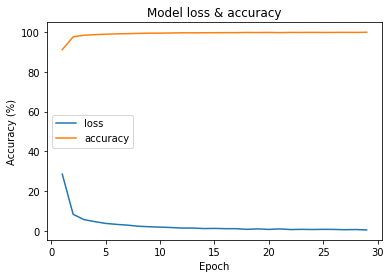

In [29]:
# Plot loass and accuracy
# Plot training & validation accuracy values
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]

epochs = range(1, len(loss_list) + 1)

plt.plot(epochs,loss_list) 
plt.plot(epochs,acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')
plt.show()

In [30]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

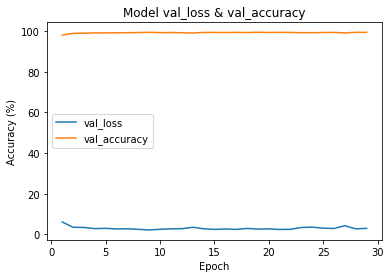

In [31]:
plt.plot(epochs,vloss_list)  
plt.plot(epochs,vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')
plt.show()

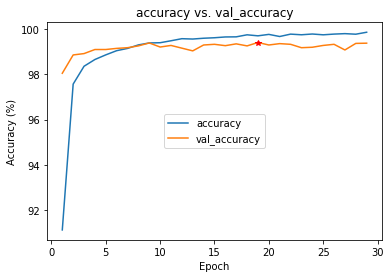

In [32]:
# vacc_list[np.argmax(np.array(vacc_list))]
plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 
plt.show()

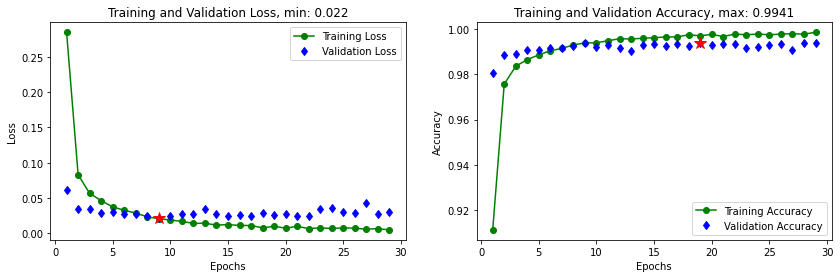

In [33]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Best model
- mnist_c2f3_best_weights.019-0.9941.hdf5

In [34]:
from keras.models import load_model

model = load_model('mnist_c2f3_best_weights.019-0.9941.hdf5')
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 1s 5ms/step - loss: 0.0262 - accuracy: 0.9941


[0.02619093842804432, 0.9940999746322632]

***

## [Next] fashion mnist model의 best model을 구하시오.

> fashion mnist 데이터 로딩
```
from keras.datasets import fashion_mnist
(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()
```

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

tf.random.set_seed(0)

print(tf.__version__)

2.7.0


In [36]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

In [37]:
from keras.datasets import fashion_mnist

(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

4431872/4422102 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [38]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [39]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((60000,), (60000, 10))

### Display Fashion-MNIST Dataset

27439


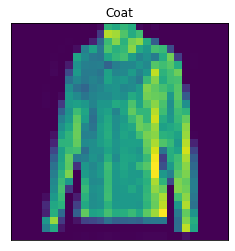

In [40]:
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

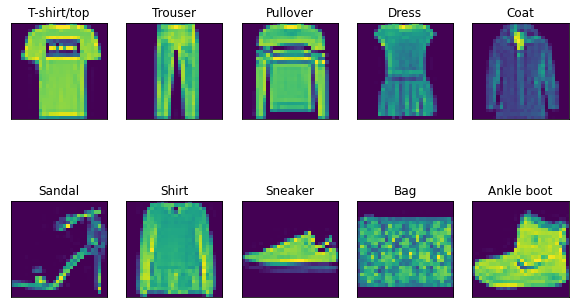

In [41]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title(class_names[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

# import models, layers, callbacks

In [42]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

# **CNN1 + FCN2**

In [61]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [62]:
fmnist_c1f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1), filters= 32, 
            kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Flatten(),
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

fmnist_c1f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [63]:
fmnist_c1f2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               802944    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                1290      
                                                      

In [64]:
mc_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c1f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10) 

In [65]:
hist = fmnist_c1f2.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 5s 8ms/step - loss: 0.4814 - accuracy: 0.8302 - val_loss: 0.3372 - val_accuracy: 0.8794
Epoch 2/500
600/600 [==============================] - 4s 7ms/step - loss: 0.3147 - accuracy: 0.8881 - val_loss: 0.2934 - val_accuracy: 0.8927
Epoch 3/500
600/600 [==============================] - 4s 7ms/step - loss: 0.2686 - accuracy: 0.9027 - val_loss: 0.2842 - val_accuracy: 0.8994
Epoch 4/500
600/600 [==============================] - 4s 7ms/step - loss: 0.2404 - accuracy: 0.9123 - val_loss: 0.2585 - val_accuracy: 0.9062
Epoch 5/500
600/600 [==============================] - 4s 7ms/step - loss: 0.2196 - accuracy: 0.9193 - val_loss: 0.2608 - val_accuracy: 0.9059
Epoch 6/500
600/600 [==============================] - 4s 7ms/step - loss: 0.2016 - accuracy: 0.9260 - val_loss: 0.2439 - val_accuracy: 0.9104
Epoch 7/500
600/600 [==============================] - 4s 7ms/step - loss: 0.1872 - accuracy: 0.9314 - val_loss: 0.2448 - val_accuracy: 0.9129

In [55]:
fmnist_c1f2.evaluate(X_test, y_test, batch_size = 100)

100/100 [==============================] - 0s 4ms/step - loss: 0.3570 - accuracy: 0.9213


[0.3570038080215454, 0.9212999939918518]

### C1F2 Best Model
- fmnist_c1f2_best_weights.016-0.9248.hdf5

In [66]:
from keras.models import load_model

model = load_model('fmnist_c1f2_best_weights.016-0.9248.hdf5')
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 1s 4ms/step - loss: 0.2647 - accuracy: 0.9248


[0.26468244194984436, 0.9247999787330627]

# **CNN1 + FCN3**

In [67]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [69]:
fmnist_c1f3 = tf.keras.models.Sequential([ 
    # tf.keras.layers.Flatten(input_shape=(28, 28)), 
    Conv2D(input_shape=(28,28,1), filters= 32,
            kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(10, activation='softmax')
])

fmnist_c1f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [70]:
fmnist_c1f3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               1605888   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                      

In [72]:
mc_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c1f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10) 

In [73]:
hist = fmnist_c1f3.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 6s 10ms/step - loss: 0.4924 - accuracy: 0.8271 - val_loss: 0.3379 - val_accuracy: 0.8778
Epoch 2/500
600/600 [==============================] - 5s 9ms/step - loss: 0.3141 - accuracy: 0.8866 - val_loss: 0.2900 - val_accuracy: 0.8911
Epoch 3/500
600/600 [==============================] - 5s 9ms/step - loss: 0.2672 - accuracy: 0.9032 - val_loss: 0.2730 - val_accuracy: 0.9017
Epoch 4/500
600/600 [==============================] - 5s 9ms/step - loss: 0.2371 - accuracy: 0.9125 - val_loss: 0.2569 - val_accuracy: 0.9065
Epoch 5/500
600/600 [==============================] - 5s 8ms/step - loss: 0.2129 - accuracy: 0.9218 - val_loss: 0.2520 - val_accuracy: 0.9102
Epoch 6/500
600/600 [==============================] - 5s 8ms/step - loss: 0.1940 - accuracy: 0.9291 - val_loss: 0.2411 - val_accuracy: 0.9146
Epoch 7/500
600/600 [==============================] - 5s 8ms/step - loss: 0.1771 - accuracy: 0.9334 - val_loss: 0.2422 - val_accuracy: 0.915

In [74]:
fmnist_c1f2.evaluate(X_test, y_test, batch_size = 100)

100/100 [==============================] - 0s 4ms/step - loss: 0.3519 - accuracy: 0.9205


[0.3518894910812378, 0.9204999804496765]

### C1F3 Best Model
- fmnist_c1f3_best_weights.013-0.9214.hdf5

In [76]:
from keras.models import load_model

model = load_model('fmnist_c1f3_best_weights.013-0.9214.hdf5')
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 1s 5ms/step - loss: 0.2580 - accuracy: 0.9214


[0.25797581672668457, 0.9214000105857849]

# **CNN2 + FCN2**

In [77]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [79]:
fmnist_c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1), filters= 64, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(filters= 32, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

fmnist_c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [80]:
fmnist_c2f2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1568)              0         
                                                                 
 dense_17 (Dense)            (None, 128)              

In [81]:
mc_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10) 

In [82]:
# Train CNN model
# Find and save the best model.
hist = fmnist_c2f2.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 6s 10ms/step - loss: 0.5301 - accuracy: 0.8091 - val_loss: 0.3599 - val_accuracy: 0.8684
Epoch 2/500
600/600 [==============================] - 6s 9ms/step - loss: 0.3427 - accuracy: 0.8780 - val_loss: 0.3126 - val_accuracy: 0.8851
Epoch 3/500
600/600 [==============================] - 5s 9ms/step - loss: 0.2923 - accuracy: 0.8936 - val_loss: 0.2861 - val_accuracy: 0.8955
Epoch 4/500
600/600 [==============================] - 6s 9ms/step - loss: 0.2642 - accuracy: 0.9033 - val_loss: 0.2696 - val_accuracy: 0.8982
Epoch 5/500
600/600 [==============================] - 6s 9ms/step - loss: 0.2425 - accuracy: 0.9121 - val_loss: 0.2672 - val_accuracy: 0.9011
Epoch 6/500
600/600 [==============================] - 6s 10ms/step - loss: 0.2240 - accuracy: 0.9178 - val_loss: 0.2489 - val_accuracy: 0.9076
Epoch 7/500
600/600 [==============================] - 6s 10ms/step - loss: 0.2074 - accuracy: 0.9235 - val_loss: 0.2489 - val_accuracy: 0.9

In [83]:
fmnist_c2f2.evaluate(X_test, y_test, batch_size =100)

100/100 [==============================] - 1s 5ms/step - loss: 0.3223 - accuracy: 0.9220


[0.32232144474983215, 0.921999990940094]

# Graph of loss and accuracy
- model: fmnist_c2f2

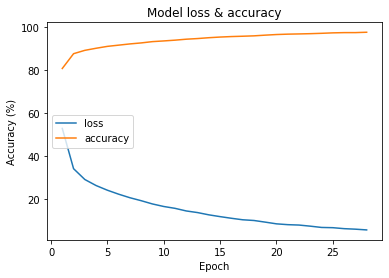

In [84]:
# Plot loass and accuracy
# Plot training & validation accuracy values
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]

epochs = range(1, len(loss_list) + 1)

plt.plot(epochs,loss_list) 
plt.plot(epochs,acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')
plt.show()

In [85]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

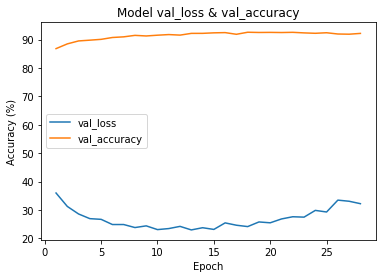

In [86]:
plt.plot(epochs,vloss_list)  
plt.plot(epochs,vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')
plt.show()

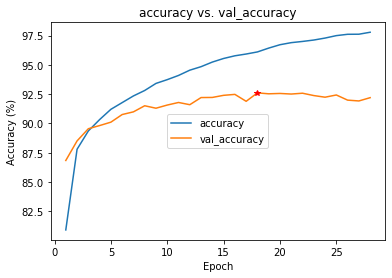

In [87]:
plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 
plt.show()

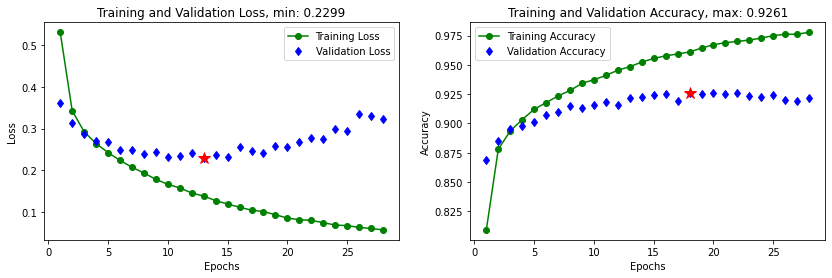

In [88]:
# 중요
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### C2F2 Best Model
- fmnist_c2f2_best_weights.018-0.9261.hdf5

In [89]:
from keras.models import load_model

model = load_model('fmnist_c2f2_best_weights.018-0.9261.hdf5')
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 1s 5ms/step - loss: 0.2417 - accuracy: 0.9261


[0.2416606992483139, 0.9261000156402588]

# **CNN2 + FCN3**

In [90]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [91]:
fmnist_c2f3 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),filters= 32, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(filters= 64, 
                kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

fmnist_c2f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [92]:
fmnist_c2f3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 3136)              0         
                                                                 
 dense_19 (Dense)            (None, 128)              

In [93]:
mc_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=10) 

In [94]:
# Train CNN model
# Find and save the best model.
hist = fmnist_c2f3.fit(X_train, y_train, epochs = 500 , batch_size =100, 
         callbacks=[mc_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
600/600 [==============================] - 7s 11ms/step - loss: 0.5894 - accuracy: 0.7859 - val_loss: 0.3774 - val_accuracy: 0.8628
Epoch 2/500
600/600 [==============================] - 6s 10ms/step - loss: 0.3673 - accuracy: 0.8706 - val_loss: 0.3122 - val_accuracy: 0.8845
Epoch 3/500
600/600 [==============================] - 6s 9ms/step - loss: 0.3107 - accuracy: 0.8888 - val_loss: 0.2932 - val_accuracy: 0.8907
Epoch 4/500
600/600 [==============================] - 6s 9ms/step - loss: 0.2774 - accuracy: 0.9006 - val_loss: 0.2688 - val_accuracy: 0.9011
Epoch 5/500
600/600 [==============================] - 6s 10ms/step - loss: 0.2509 - accuracy: 0.9091 - val_loss: 0.2585 - val_accuracy: 0.9072
Epoch 6/500
600/600 [==============================] - 6s 9ms/step - loss: 0.2307 - accuracy: 0.9164 - val_loss: 0.2395 - val_accuracy: 0.9136
Epoch 7/500
600/600 [==============================] - 6s 9ms/step - loss: 0.2127 - accuracy: 0.9229 - val_loss: 0.2354 - val_accuracy: 0.9

In [95]:
fmnist_c2f3.evaluate(X_test, y_test, batch_size =100)

100/100 [==============================] - 0s 5ms/step - loss: 0.3550 - accuracy: 0.9229


[0.354977548122406, 0.9229000210762024]

# Graph of loss and accuracy
- model: fmnist_c2f3

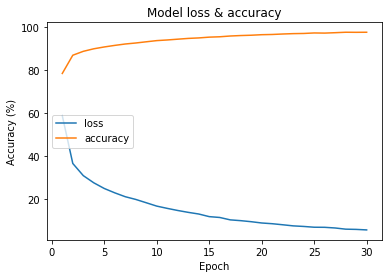

In [96]:
# Plot loass and accuracy
# Plot training & validation accuracy values
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]

epochs = range(1, len(loss_list) + 1)

plt.plot(epochs,loss_list) 
plt.plot(epochs,acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')
plt.show()

In [97]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

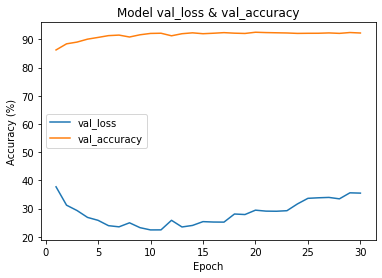

In [98]:
plt.plot(epochs,vloss_list)  
plt.plot(epochs,vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')
plt.show()

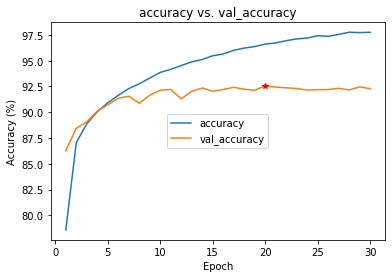

In [99]:
plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 
plt.show()

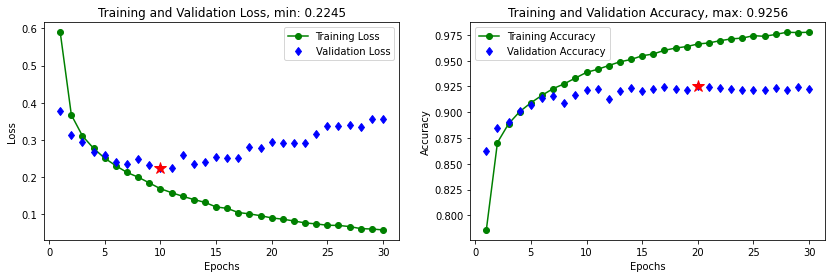

In [100]:
# 중요
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## C2F3 Best Model
- fmnist_c2f3_best_weights.020-0.9256.hdf5

In [101]:
from keras.models import load_model

model = load_model('fmnist_c2f3_best_weights.020-0.9256.hdf5')
model.evaluate(X_test, y_test, batch_size=100)

100/100 [==============================] - 1s 5ms/step - loss: 0.2945 - accuracy: 0.9256


[0.2945386469364166, 0.925599992275238]

---